In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pickle as pkl
from mpl_toolkits.basemap import Basemap
# To install basemap
# !apt-get install libgeos-3.5.0
# !apt-get install libgeos-dev
# !pip install https://github.com/matplotlib/basemap/archive/master.zip
# !pip install pyproj==1.9.6

%matplotlib inline

# Make reproducible
seed = 0
np.random.seed(seed)

In [0]:
SMALL_SIZE = 8
MEDIUM_SIZE = 9
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

plt.rc('text', usetex=False)

In [0]:
def recube(in_array):

    lat_len = 48
    lon_len = 96
    time_len = 240

    output = np.zeros([time_len, lat_len, lon_len])

    for t in range(time_len):
        output[t,:,:] = in_array[lat_len * lon_len * (t): lat_len * lon_len * (t+1)].reshape([lat_len, lon_len])
    
    return output

In [0]:
# Load coefficients
alpha = pkl.load(open('/content/gdrive/My Drive/data/toy_alpha.pkl', 'rb'))
beta = pkl.load(open('/content/gdrive/My Drive/data/toy_beta.pkl', 'rb'))
noise = pkl.load(open('/content/gdrive/My Drive/data/toy_aleatoric_noise.pkl', 'rb'))

In [0]:
# Set up basemap plots
m=Basemap(lat_0=0, lon_0=0, projection='robin', resolution='c')
lon = np.arange(-180 + 1.875,180,360/96)
lat = np.arange(-90 + 1.875, 90, 180/48)
lons, lats = np.meshgrid(lon, lat)
x,y = m(lons, lats)

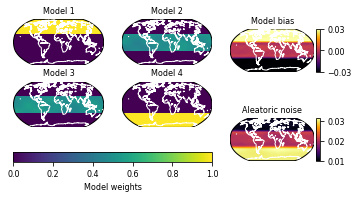

In [19]:
# Plot model coefficients
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(5.5,3))

p1 = m.pcolormesh(x, y, recube(alpha[:, 0])[180], vmin=0, vmax=1, ax=axes[0][0])
axes[0][0].xaxis.set_ticklabels([])
axes[0][0].title.set_text('Model 1')
m.drawcoastlines(color='white', ax=axes[0][0])

p2 = m.pcolormesh(x, y, recube(alpha[:, 1])[180], vmin=0, vmax=1, ax=axes[0][1])
axes[0][1].xaxis.set_ticklabels([])
axes[0][1].yaxis.set_ticklabels([])
axes[0][1].title.set_text('Model 2')
m.drawcoastlines(color='white', ax=axes[0][1])

p3 = m.pcolormesh(x, y, recube(alpha[:, 2])[180], vmin=0, vmax=1, ax=axes[1][0])
axes[1][0].title.set_text('Model 3')
m.drawcoastlines(color='white', ax=axes[1][0])

p4  = m.pcolormesh(x, y, recube(alpha[:, 3])[180], vmin=0, vmax=1, ax=axes[1][1])
axes[1][1].yaxis.set_ticklabels([])
axes[1][1].title.set_text('Model 4')
m.drawcoastlines(color='white', ax=axes[1][1])

p5 = m.pcolormesh(x, y, recube(beta)[180], vmin=-0.03, vmax=0.03, ax=axes[0][2], cmap=plt.cm.inferno)
axes[0][2].yaxis.set_ticklabels([])
axes[0][2].title.set_text('Model bias')
m.drawcoastlines(color='white', ax=axes[0][2], )
cbar = m.colorbar(p5, ax=axes[0][2])
cbar.set_ticks([-0.03,0,0.03])

p6 = m.pcolormesh(x, y, noise[180], ax=axes[1][2], vmin=0.01, cmap=plt.cm.inferno)
axes[1][2].yaxis.set_ticklabels([])
axes[1][2].title.set_text('Aleatoric noise')
m.drawcoastlines(color='white', ax=axes[1][2])
m.colorbar(p6, ax=axes[1][2])

cb = fig.colorbar(p4, ax=axes[:2, :2].ravel().tolist(), location='bottom')
cb.set_label('Model weights')

# Generating synthetic model data

In [0]:
# Create fake dimensions (lat, lon, months, time)
n_years = 20
lats = np.arange(-90, 90, 180/48)
lons = np.arange(-180,180, 360/96)
# Change time so the in sample runs -1, 1
time = np.arange(-1,1, (2/12)/n_years) * 2 + 1
months = np.tile(np.arange(-1,1,2/12), n_years)

# Create smooth function to serve as the observational truth
def fun(time, lat, lon, month):
    f = (0.5 * (((lat/90)  ** 2) + 0.5 * np.sin(2 * np.pi * lon/180)) - 0.2 * np.cos(np.pi * month))
    return f

obs = np.zeros([len(time), len(lats), len(lons)])
for i, t in enumerate(time):
    for j, lat in enumerate(lats):
        for k, lon in enumerate(lons):
            obs[i, j, k] = fun(t, lat, lon, months[i])
            
# Normalise obs
obs = 2 * (obs - obs.min())/(obs.max() - obs.min()) - 1

In [0]:
# Format data so it is suitable for NN input
data_len = obs.size
lon_data = np.tile(lons, int(data_len / len(lons))).reshape(-1,)
lat_data = np.tile(np.repeat(lats, len(lons)), len(time)).reshape(-1,)
time_data = np.repeat(time, int(data_len / len(time))).reshape(-1,)
mon_data = np.repeat(months, int(data_len / len(time))).reshape(-1,)

# model 1  True in the north with a -0.03 bias
mdl1 = obs.copy() - 0.03 + np.random.normal(size=[len(time), len(lats), len(lons)]) * 0.005
mdl1[:,:-16, :] = np.random.random([len(time), len(lats) - 16, len(lons)]) * 2 - 1

# model 2 True around equator with no bias
mdl2 = obs.copy() + np.random.normal(size=[len(time),len(lats), len(lons)]) * 0.005 
mdl2[:,:16, :] = np.random.random([len(time), 16, len(lons)]) * 2 - 1
mdl2[:,-16:, :] = np.random.random([len(time), 16, len(lons)]) * 2 - 1

# model 3 True around equator with no bias (as per model 2)
mdl3 = obs.copy() + np.random.normal(size=[len(time), len(lats), len(lons)]) * 0.005
mdl3[:,:16, :] = np.random.random([len(time), 16, len(lons)]) * 2 - 1
mdl3[:,-16:, :] = np.random.random([len(time), 16, len(lons)]) * 2 - 1

# model 4 True in the south with 0.03 bias. True only for months 1-6
mdl4 = obs.copy() + 0.03 + np.random.normal(size=[len(time), len(lats), len(lons)]) * 0.005
mdl4[:,16:, :] = np.random.random([len(time), len(lats) - 16, len(lons)]) * 2 - 1

# Add noise
# In the north we have 0.01 noise
obs[:,-16:, :] = obs[:,-16:, :] + np.random.normal(size=obs[:,-16:, :].shape) * 0.01
# Around the equator we have 0.02 noise
obs[:,16:-16, :] = obs[:,16:-16, :] + np.random.normal(size=obs[:,16:-16, :].shape) * 0.02
# In the south we have 0.03 noise
obs[:,:16, :] = obs[:,:16, :] + np.random.normal(size=obs[:,:16, :].shape) * 0.03

[]

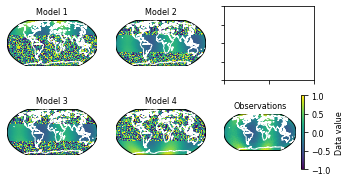

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(5.5,3))

p1 = m.pcolormesh(x, y, mdl1[180], vmin=-1, vmax=1, ax=axes[0][0])
axes[0][0].xaxis.set_ticklabels([])
axes[0][0].title.set_text('Model 1')
m.drawcoastlines(color='white', ax=axes[0][0])

p2 = m.pcolormesh(x, y, mdl2[180], vmin=-1, vmax=1, ax=axes[0][1])
axes[0][1].xaxis.set_ticklabels([])
axes[0][1].title.set_text('Model 2')
m.drawcoastlines(color='white', ax=axes[0][1])

p3 = m.pcolormesh(x, y, mdl4[180], vmin=-1, vmax=1, ax=axes[1][1])
axes[1][1].xaxis.set_ticklabels([])
axes[1][1].title.set_text('Model 4')
m.drawcoastlines(color='white', ax=axes[1][1])

p4 = m.pcolormesh(x, y, mdl3[180], vmin=-1, vmax=1, ax=axes[1][0])
axes[1][0].xaxis.set_ticklabels([])
axes[1][0].title.set_text('Model 3')
m.drawcoastlines(color='white', ax=axes[1][0])

# cb = fig.colorbar(p4, ax=axes[1, 0])
# cb.set_label('Data value')

p5 = m.pcolormesh(x, y, obs[180], vmin=-1, vmax=1, ax=axes[1][2])
axes[1][2].xaxis.set_ticklabels([])
axes[1][2].title.set_text('Observations')
m.drawcoastlines(color='white', ax=axes[1][2])
cb = fig.colorbar(p5, ax=axes[1, 2])
cb.set_label('Data value')

axes[0][2].xaxis.set_ticklabels([])
axes[0][2].yaxis.set_ticklabels([])